In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorlayer as tl
import os
import matplotlib.pyplot as plt

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
input_data = pd.read_csv('data/comma_LSTM_data_R867_20170915_T4_clu1_Tr1.txt')
input_data.columns=['x','y','dir','c']

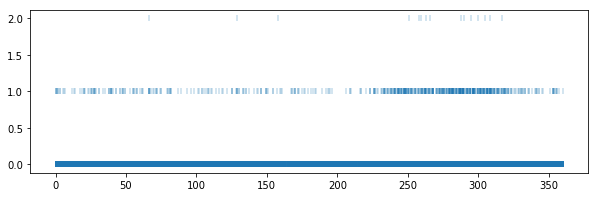

In [4]:
plt.figure(figsize=(10,3))
plt.scatter(input_data['dir'],input_data['c'],marker="|",alpha=0.25)
plt.show()

In [5]:
X_all = np.array([input_data['x'],input_data['y'],input_data['dir']]).T
Y_all = np.array([input_data['c']])

In [6]:
in_n = len(input_data)
X_train = X_all[:int(4*in_n/6)]
X_val = X_all[int(4*in_n/6):int(5*in_n/6)]
X_test = X_all[int(5*in_n/6):]
Y_train = Y_all[:int(4*in_n/6)]
Y_val = Y_all[int(4*in_n/6):int(5*in_n/6)]
Y_test = Y_all[int(5*in_n/6):]

In [71]:
learning_rate = 0.1
training_steps = 300
display_step = 1
bs = X_train.shape[0]
reg_const = 0.001
rnn_hidden = 100
dropout = 0.5
seq_len = 1000

In [72]:
sl = np.empty(bs)
sl.fill(seq_len)

In [73]:
tf.reset_default_graph()
with tf.name_scope('input'):
    X=tf.placeholder(tf.float32,[None,seq_len,X_train.shape[1]],name="xydir")
    Y=tf.placeholder(tf.float32,[None,Y_train.shape[1]],name="neuron_output")
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    reg_const = tf.placeholder(tf.float32,name='reg_const')
    batch_size=tf.placeholder(tf.int32,[],name="batch_size")
    #dropout = tf.placeholder(tf.float32)
with tf.name_scope('LSTM_cell'):
    cell = tf.contrib.rnn.BasicLSTMCell(
                                        rnn_hidden,
                                        forget_bias=1.0,
                                        state_is_tuple=True)
    #dcell = tf.contrib.rnn.DropoutWrapper(cell,output_keep_prob=dropout)
    init_state = cell.zero_state(batch_size,dtype=tf.float32)
    outputs,final_state = tf.nn.dynamic_rnn(
                                            cell,
                                            X,
                                            initial_state=init_state)
                                            #time_major=False)

In [74]:
with tf.name_scope('FC_weights'):
    fV = tf.Variable(tf.random_uniform([rnn_hidden,Y_train.shape[1]]),name="fV")
    fV_reg = tf.reduce_sum(tf.square(fV))
    tf.summary.histogram('fV',fV)
with tf.name_scope('FC_biases'):
    fb = tf.Variable(tf.zeros([Y_train.shape[1]]),name="fb")

In [75]:
with tf.name_scope('l_regress'):
    h_in = outputs[1]
    u = tf.nn.relu(tf.add(tf.matmul(h_in,fV),fb))
with tf.name_scope('lossandpred'):
    pred = tf.nn.softmax(u)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=u)) \
            + tf.multiply(reg_const,fV_reg)
    tf.summary.scalar('loss',loss)
    tf.summary.histogram('preds',pred)
with tf.name_scope('train'):
    optim = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    number_of_zeros = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1),0),tf.float32))
    tf.summary.scalar('accuracy',accuracy)
    tf.summary.scalar('number_of_zeros',number_of_zeros) 

In [76]:
run=0

In [84]:
init = tf.global_variables_initializer()
run +=1
lrate = 0.01#[0.1,0.05,0.01,0.005,0.001,0.0005] 
regc = 1#[100,10,1.0,0.1,0.01,0.001,0.0001,0]
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('tb/lstm_1/train/l%.4f.r%.4f.run%d'%(lrate,regc,run), sess.graph)
    val_writer = tf.summary.FileWriter('tb/lstm_1/val/l%.4f.r%.4f.run%d'%(lrate,regc,run), sess.graph)
    sess.run(init)
    merged = tf.summary.merge_all()
    steps_per_epoch = int(X_train.shape[0]/bs)
    num_epochs = int(training_steps/steps_per_epoch)
    for epoch in range(num_epochs):
        for step in range(steps_per_epoch):
            sess.run(optim,feed_dict={X:X_train,
                                      Y:Y_train,
                                      learning_rate:lrate,
                                      reg_const:regc,
                                      batch_size:bs})
            summary = sess.run(merged, feed_dict={X:X_train[:bs],
                                                      Y:Y_train[:bs],
                                                      batch_size:bs,
                                                      reg_const:regc})
            train_writer.add_summary(summary,total_step)
            


ValueError: Cannot feed value of shape (16033, 3) for Tensor 'input/xydir:0', which has shape '(?, 1000, 3)'